# SetUp

## import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install statsmodels
!pip install holidays
!pip install pmdarima
!pip install plotly xgboost tensorflow pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.3 MB/s eta 0:00:00


In [ ]:
# Import packages and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import xgboost as xgb

import tensorflow as tf
import pmdarima as pm
import lightgbm as lgb
import holidays
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score , make_scorer, mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestRegressor

from tensorflow.keras import regularizers, Sequential, layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LSTM
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import learning_curve


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, GRU, Normalization, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
pd.set_option('display.max_columns', None)

# Data Loading

## Read csv

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Renewable_Energy/raw_data/powerconsumption.csv')
df.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


# Data Cleaning

## Handle Missings

It is clear that we have outliers in the Diffuse Flows and General Diffuse Flows.

In [ ]:
def detailed_check_df(dataframe, head=5):
    print("Shape:")
    print(dataframe.shape)

    print("Info:")
    # what is memory_usage attribute?
    # If we have large strings, we can convert them to other types, such as categories, to save space.
    print(dataframe.info(memory_usage='deep'))

    print("Types:")
    print(dataframe.dtypes)

    print("Missing Values:")
    missing_values = dataframe.isnull().sum()
    print(missing_values[missing_values > 0])

    print("Unique Values:")
    for column in dataframe.columns:
        print(f"{column} has {dataframe[column].nunique()} unique values")

detailed_check_df(df)

Shape:
(52416, 9)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Datetime                52416 non-null  object 
 1   Temperature             52416 non-null  float64
 2   Humidity                52416 non-null  float64
 3   WindSpeed               52416 non-null  float64
 4   GeneralDiffuseFlows     52416 non-null  float64
 5   DiffuseFlows            52416 non-null  float64
 6   PowerConsumption_Zone1  52416 non-null  float64
 7   PowerConsumption_Zone2  52416 non-null  float64
 8   PowerConsumption_Zone3  52416 non-null  float64
dtypes: float64(8), object(1)
memory usage: 6.8 MB
None
Types:
Datetime                   object
Temperature               float64
Humidity                  float64
WindSpeed                 float64
GeneralDiffuseFlows       float64
DiffuseFlows              float64
PowerConsumption_Z

In [ ]:
df.isna().sum()

,0
Datetime,0
Temperature,0
Humidity,0
WindSpeed,0
GeneralDiffuseFlows,0
DiffuseFlows,0
PowerConsumption_Zone1,0
PowerConsumption_Zone2,0
PowerConsumption_Zone3,0


The outliers are clearly visible in both GeneralDiffuseFlows and DiffuseFlows

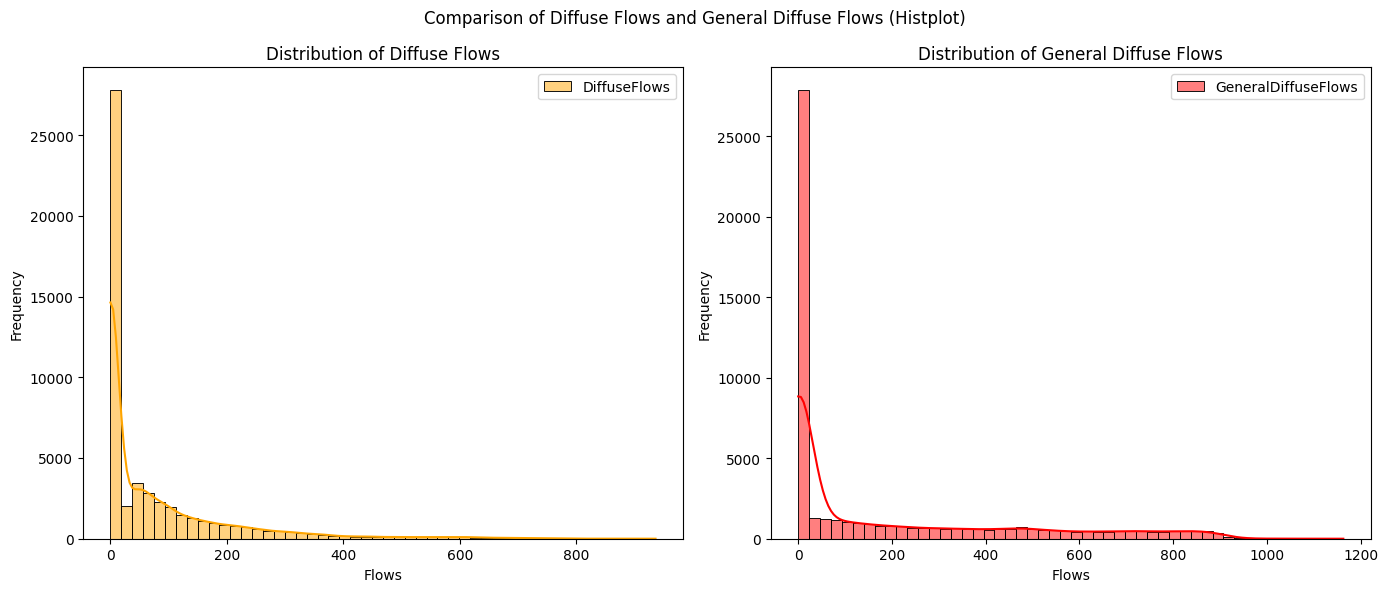

In [ ]:
# plotting the histograms for DiffuseFlows and GeneralDiffuseFlows using histplot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Diffuse Flows
sns.histplot(df['DiffuseFlows'], kde=True, label='DiffuseFlows', color='orange', bins=50, ax=ax[0])
ax[0].set_title('Distribution of Diffuse Flows')
ax[0].set_xlabel('Flows')
ax[0].set_ylabel('Frequency')
ax[0].legend()

# Plot for General Diffuse Flows
sns.histplot(df['GeneralDiffuseFlows'], kde=True, label='GeneralDiffuseFlows', color='red', bins=50, ax=ax[1])
ax[1].set_title('Distribution of General Diffuse Flows')
ax[1].set_xlabel('Flows')
ax[1].set_ylabel('Frequency')
ax[1].legend()

plt.suptitle('Comparison of Diffuse Flows and General Diffuse Flows (Histplot)')
plt.tight_layout()
plt.show()

Remove unnecessary columns

In [ ]:
df = df.drop(columns = [ 'DiffuseFlows', 'GeneralDiffuseFlows'])

In [ ]:
df.dtypes

,0
Datetime,object
Temperature,float64
Humidity,float64
WindSpeed,float64
PowerConsumption_Zone1,float64
PowerConsumption_Zone2,float64
PowerConsumption_Zone3,float64


# Data Preparing

## DateTime index

In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'],format='%m/%d/%Y %H:%M')
df.set_index('Datetime', inplace=True)

df.head()

,Temperature,Humidity,WindSpeed,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
Datetime,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,27335.69620,17872.34043,18442.40964


In [ ]:
# Create new columns using the Datetime index
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['Hour'] = df.index.hour
df.head()

,Temperature,Humidity,WindSpeed,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Year,Month,Day,Hour
Datetime,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,34055.69620,16128.87538,20240.96386,2017,1,1,0
2017-01-01 00:10:00,6.414,74.5,0.083,29814.68354,19375.07599,20131.08434,2017,1,1,0
2017-01-01 00:20:00,6.313,74.5,0.080,29128.10127,19006.68693,19668.43373,2017,1,1,0
2017-01-01 00:30:00,6.121,75.0,0.083,28228.86076,18361.09422,18899.27711,2017,1,1,0
2017-01-01 00:40:00,5.921,75.7,0.081,27335.69620,17872.34043,18442.40964,2017,1,1,0


## Add IsHoliday column

### Insert the 2017 Moroccan Holiday Dataset


Holidays in Morocco for the year 2017 will be added using a holidays library. The goal is to introduce a new feature to the dataset, allowing us to measure electricity consumption on holidays versus non-holidays.

In [ ]:
df.index = pd.to_datetime(df.index)
df['Date'] = df.index.date

# Initialize the Morocco holidays for the year 2017
morocco_holidays = holidays.Morocco(years=[2017])

# Add the 'IsHoliday' column
df['IsHoliday'] = df['Date'].apply(lambda x: 1 if x in morocco_holidays else 0)
df = df.drop(columns = ['Date'])

df.head()

,Temperature,Humidity,WindSpeed,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Year,Month,Day,Hour,IsHoliday
Datetime,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,34055.69620,16128.87538,20240.96386,2017,1,1,0,1
2017-01-01 00:10:00,6.414,74.5,0.083,29814.68354,19375.07599,20131.08434,2017,1,1,0,1
2017-01-01 00:20:00,6.313,74.5,0.080,29128.10127,19006.68693,19668.43373,2017,1,1,0,1
2017-01-01 00:30:00,6.121,75.0,0.083,28228.86076,18361.09422,18899.27711,2017,1,1,0,1
2017-01-01 00:40:00,5.921,75.7,0.081,27335.69620,17872.34043,18442.40964,2017,1,1,0,1


### Morocco holidays for 2017

#### To ensure accuracy, this is list all holidays for Morocco in 2017 generated by the holidays library.

In [ ]:
# Print all holidays in Morocco for 2017
for date, name in sorted(morocco_holidays.items()):
    print(date, name)

2017-01-01 New Year's Day
2017-01-11 Proclamation of Independence Day
2017-05-01 Labor Day
2017-06-25 Eid al-Fitr (estimated)
2017-06-26 Eid al-Fitr (estimated)
2017-07-30 Throne Day
2017-08-14 Oued Ed-Dahab Day
2017-08-20 Revolution Day
2017-08-21 Youth Day
2017-09-01 Eid al-Adha (estimated)
2017-09-02 Eid al-Adha (estimated)
2017-09-21 Islamic New Year (estimated)
2017-11-06 Green March
2017-11-18 Independence Day
2017-11-30 Prophet's Birthday (estimated)
2017-12-01 Prophet's Birthday (estimated)


In [ ]:
df.head()

,Temperature,Humidity,WindSpeed,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Year,Month,Day,Hour,IsHoliday
Datetime,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,34055.69620,16128.87538,20240.96386,2017,1,1,0,1
2017-01-01 00:10:00,6.414,74.5,0.083,29814.68354,19375.07599,20131.08434,2017,1,1,0,1
2017-01-01 00:20:00,6.313,74.5,0.080,29128.10127,19006.68693,19668.43373,2017,1,1,0,1
2017-01-01 00:30:00,6.121,75.0,0.083,28228.86076,18361.09422,18899.27711,2017,1,1,0,1
2017-01-01 00:40:00,5.921,75.7,0.081,27335.69620,17872.34043,18442.40964,2017,1,1,0,1


## Time of Day and Weekend Classification

Time-of-day categories will be added based on the hour, and new columns will be added to determine the day of the week and whether it's a weekend or not.

In [ ]:
# Define time of day categories
def categorize_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

# Categorize the time of day using the 'Hour' column
df['TimeOfDay'] = df['Hour'].apply(categorize_time_of_day)

# Add day of the week and check if it is a weekend
df['Weekday'] = df.index.weekday  # Access weekday from index
# Add a column to indicate if it's a weekend
df['IsWeekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)

df = df.drop(columns = ['Weekday'])

## Season Classification

Months will be classified into seasons, a "Season" column will be added, and specific columns will be converted to numeric types.

In [ ]:
# Define the seasons
def categorize_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(categorize_season)

# Let's set the data types to numeric
df['Year'] = df['Year'].astype(int)
df['IsWeekend'] = df['IsWeekend'].astype(int)
df.head()

,Temperature,Humidity,WindSpeed,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Year,Month,Day,Hour,IsHoliday,TimeOfDay,IsWeekend,Season
Datetime,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,34055.69620,16128.87538,20240.96386,2017,1,1,0,1,Night,1,Winter
2017-01-01 00:10:00,6.414,74.5,0.083,29814.68354,19375.07599,20131.08434,2017,1,1,0,1,Night,1,Winter
2017-01-01 00:20:00,6.313,74.5,0.080,29128.10127,19006.68693,19668.43373,2017,1,1,0,1,Night,1,Winter
2017-01-01 00:30:00,6.121,75.0,0.083,28228.86076,18361.09422,18899.27711,2017,1,1,0,1,Night,1,Winter
2017-01-01 00:40:00,5.921,75.7,0.081,27335.69620,17872.34043,18442.40964,2017,1,1,0,1,Night,1,Winter


## Zones

### dealing with one city better than multi-zones

In [ ]:
df['TotalPowerConsumption'] = df['PowerConsumption_Zone1'] + df['PowerConsumption_Zone2'] + df['PowerConsumption_Zone3']
df.head()

,Temperature,Humidity,WindSpeed,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Year,Month,Day,Hour,IsHoliday,TimeOfDay,IsWeekend,Season,TotalPowerConsumption
Datetime,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,34055.69620,16128.87538,20240.96386,2017,1,1,0,1,Night,1,Winter,70425.53544
2017-01-01 00:10:00,6.414,74.5,0.083,29814.68354,19375.07599,20131.08434,2017,1,1,0,1,Night,1,Winter,69320.84387
2017-01-01 00:20:00,6.313,74.5,0.080,29128.10127,19006.68693,19668.43373,2017,1,1,0,1,Night,1,Winter,67803.22193
2017-01-01 00:30:00,6.121,75.0,0.083,28228.86076,18361.09422,18899.27711,2017,1,1,0,1,Night,1,Winter,65489.23209
2017-01-01 00:40:00,5.921,75.7,0.081,27335.69620,17872.34043,18442.40964,2017,1,1,0,1,Night,1,Winter,63650.44627


### Drop all zones

In [ ]:
df.drop(columns=['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3'], inplace=True)
df.head()

,Temperature,Humidity,WindSpeed,Year,Month,Day,Hour,IsHoliday,TimeOfDay,IsWeekend,Season,TotalPowerConsumption
Datetime,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,2017,1,1,0,1,Night,1,Winter,70425.53544
2017-01-01 00:10:00,6.414,74.5,0.083,2017,1,1,0,1,Night,1,Winter,69320.84387
2017-01-01 00:20:00,6.313,74.5,0.080,2017,1,1,0,1,Night,1,Winter,67803.22193
2017-01-01 00:30:00,6.121,75.0,0.083,2017,1,1,0,1,Night,1,Winter,65489.23209
2017-01-01 00:40:00,5.921,75.7,0.081,2017,1,1,0,1,Night,1,Winter,63650.44627


### Average income per capita in Morocco by year

In [ ]:
AverageIncome_2017= 3288.50
AverageIncome_2024= 3489
# https://ycharts.com/indicators/morocco_gdp_per_capita_usd

df.head()

,Temperature,Humidity,WindSpeed,Year,Month,Day,Hour,IsHoliday,TimeOfDay,IsWeekend,Season,TotalPowerConsumption
Datetime,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,2017,1,1,0,1,Night,1,Winter,70425.53544
2017-01-01 00:10:00,6.414,74.5,0.083,2017,1,1,0,1,Night,1,Winter,69320.84387
2017-01-01 00:20:00,6.313,74.5,0.080,2017,1,1,0,1,Night,1,Winter,67803.22193
2017-01-01 00:30:00,6.121,75.0,0.083,2017,1,1,0,1,Night,1,Winter,65489.23209
2017-01-01 00:40:00,5.921,75.7,0.081,2017,1,1,0,1,Night,1,Winter,63650.44627


##  ENCODING -OneHotIncoder


In [ ]:
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(df[['Season', 'TimeOfDay']])
df[ohe.get_feature_names_out(['Season', 'TimeOfDay'])] = ohe.transform(df[['Season', 'TimeOfDay']])
df = df.drop(columns = ['Season', 'TimeOfDay'])

df.head()

,Temperature,Humidity,WindSpeed,Year,Month,Day,Hour,IsHoliday,IsWeekend,TotalPowerConsumption,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,TimeOfDay_Afternoon,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night
Datetime,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,2017,1,1,0,1,1,70425.53544,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-01-01 00:10:00,6.414,74.5,0.083,2017,1,1,0,1,1,69320.84387,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-01-01 00:20:00,6.313,74.5,0.080,2017,1,1,0,1,1,67803.22193,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-01-01 00:30:00,6.121,75.0,0.083,2017,1,1,0,1,1,65489.23209,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-01-01 00:40:00,5.921,75.7,0.081,2017,1,1,0,1,1,63650.44627,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


# Exploratory Data Analysis 📊

## Correlation Analysis

In [ ]:
# Calculate the correlation coefficient between Total consumption and each factor.
correlation_temp = df['TotalPowerConsumption'].corr(df['Temperature'])
correlation_humidity = df['TotalPowerConsumption'].corr(df['Humidity'])
correlation_wind_speed = df['TotalPowerConsumption'].corr(df['WindSpeed'])
correlation_isHoliday = df['TotalPowerConsumption'].corr(df['IsHoliday'])

# print the results
print("Correlation with Temperature:", correlation_temp)
print("Correlation with Humidity:", correlation_humidity)
print("Correlation with Wind Speed:", correlation_wind_speed)
print("Correlation with Is Holday:", correlation_isHoliday)

Correlation with Temperature: 0.4882384320045328
Correlation with Humidity: -0.29905902107542187
Correlation with Wind Speed: 0.2217061054966012
Correlation with Is Holday: -0.00394457293994302


In [ ]:
df.head()

,Temperature,Humidity,WindSpeed,Year,Month,Day,Hour,IsHoliday,IsWeekend,TotalPowerConsumption,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,TimeOfDay_Afternoon,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night
Datetime,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,2017,1,1,0,1,1,70425.53544,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-01-01 00:10:00,6.414,74.5,0.083,2017,1,1,0,1,1,69320.84387,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-01-01 00:20:00,6.313,74.5,0.080,2017,1,1,0,1,1,67803.22193,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-01-01 00:30:00,6.121,75.0,0.083,2017,1,1,0,1,1,65489.23209,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-01-01 00:40:00,5.921,75.7,0.081,2017,1,1,0,1,1,63650.44627,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Visualize relationships

In [ ]:
df.columns

Index(['Temperature', 'Humidity', 'WindSpeed', 'Year', 'Month', 'Day', 'Hour',
       'IsHoliday', 'IsWeekend', 'TotalPowerConsumption', 'Season_Autumn',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'TimeOfDay_Afternoon', 'TimeOfDay_Evening', 'TimeOfDay_Morning',
       'TimeOfDay_Night'],
      dtype='object')

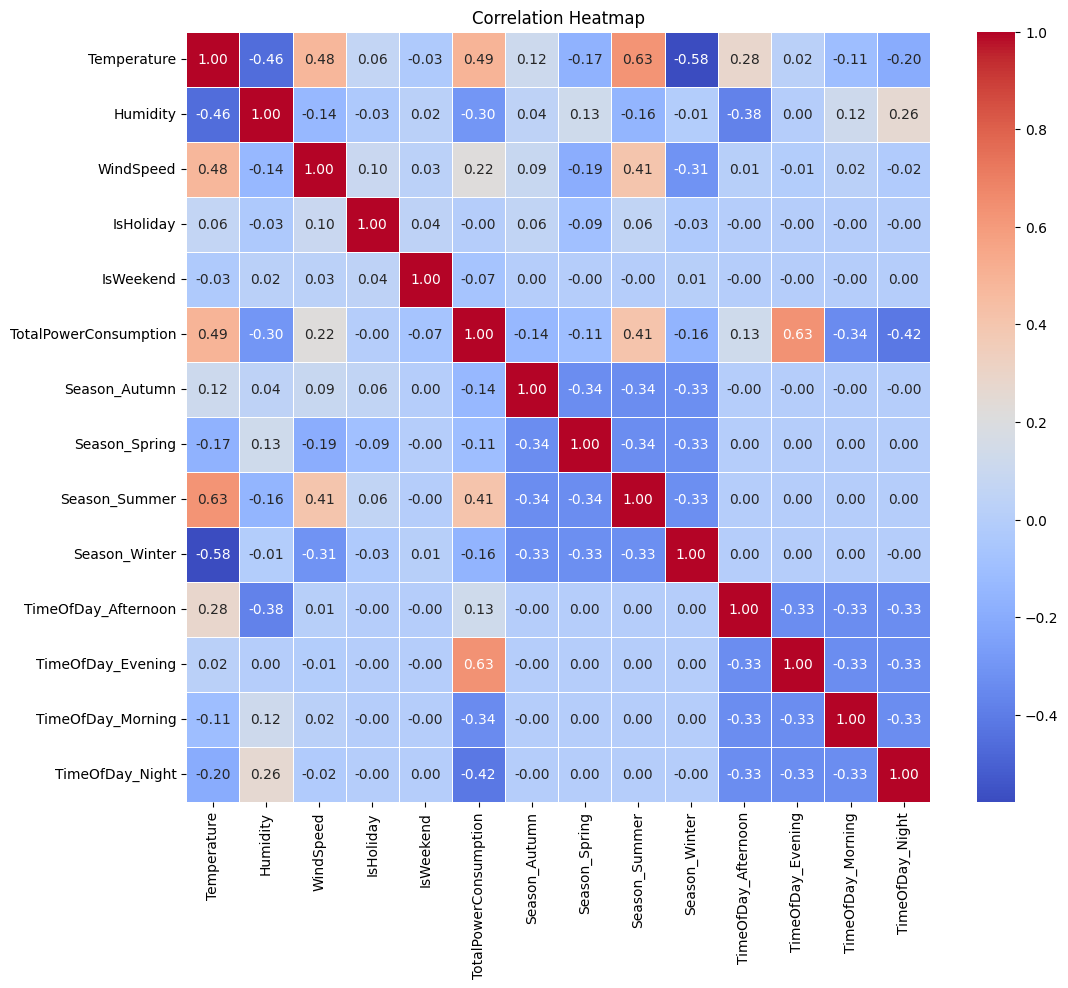

In [ ]:
columns_to_include = ['Temperature', 'Humidity', 'WindSpeed',
       'Month', 'Day', 'Hour', 'IsHoliday', 'Weekday',
       'IsWeekend', 'TotalPowerConsumption', 'Week', 'Season_Autumn', 'Season_Spring',
       'Season_Summer', 'Season_Winter', 'TimeOfDay_Afternoon', 'TimeOfDay_Evening',
       'TimeOfDay_Morning', 'TimeOfDay_Night']

# Check if columns exist in DataFrame
existing_columns = [col for col in columns_to_include if col in df.columns]

# Calculate correlation matrix for existing columns only
correlation_matrix = df[existing_columns].select_dtypes(include=['float64', 'int64']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Converts the date index to weekly periods, groups data by week to calculate the mean energy consumption, and creates an interactive box plot using Plotly to visualize weekly energy consumption. It customizes the x-axis for better readability and displays all outliers.

# Resample

## Daily Resample

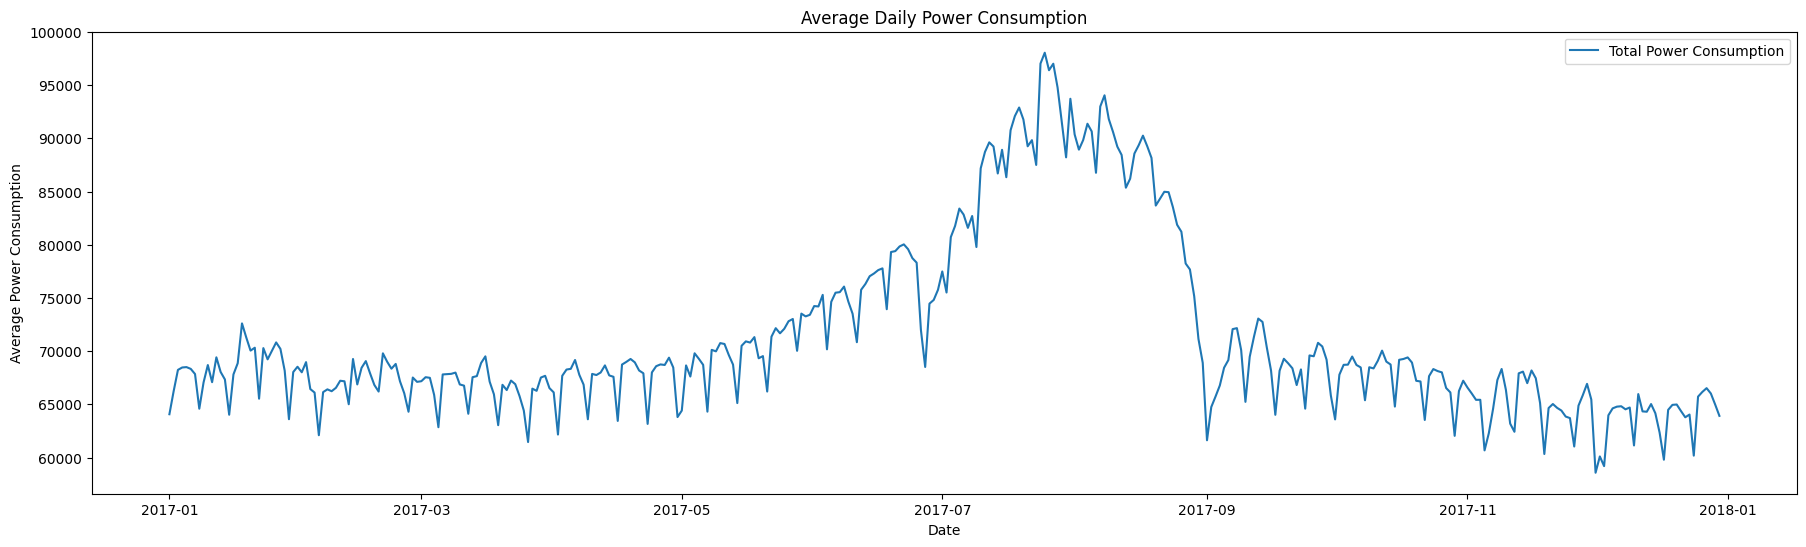

In [ ]:
# Resample the 'TotalPowerConsumption' column to daily frequency and calculate the mean
daily_resampled = df['TotalPowerConsumption'].resample('D').mean()

# Plot daily Total Power Consumption
plt.figure(figsize=(22, 6))
sns.lineplot(data=daily_resampled)
plt.xlabel('Date')
plt.ylabel('Average Power Consumption')
plt.title('Average Daily Power Consumption')
plt.legend(labels=['Total Power Consumption'])
plt.show()

### Per Capita Consumption


### Population in the city of Tetouan

The total population will be used to calculate per capita consumption, which is what we aim to predict in the models.



In [ ]:
total_individuals = 399817
df.head()

,Temperature,Humidity,WindSpeed,Year,Month,Day,Hour,IsHoliday,IsWeekend,TotalPowerConsumption,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,TimeOfDay_Afternoon,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night
Datetime,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,2017,1,1,0,1,1,70425.53544,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-01-01 00:10:00,6.414,74.5,0.083,2017,1,1,0,1,1,69320.84387,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-01-01 00:20:00,6.313,74.5,0.080,2017,1,1,0,1,1,67803.22193,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-01-01 00:30:00,6.121,75.0,0.083,2017,1,1,0,1,1,65489.23209,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-01-01 00:40:00,5.921,75.7,0.081,2017,1,1,0,1,1,63650.44627,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
df['PerCapitaConsumption'] = df['TotalPowerConsumption'] / total_individuals

### Average income per capita in Morocco by year

In [ ]:
AverageIncome_2017= 3288.50
AverageIncome_2024= 3489
# source: https://ycharts.com/indicators/morocco_gdp_per_capita_usd

df.head()

,Temperature,Humidity,WindSpeed,Year,Month,Day,Hour,IsHoliday,IsWeekend,TotalPowerConsumption,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,TimeOfDay_Afternoon,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night,PerCapitaConsumption
Datetime,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,2017,1,1,0,1,1,70425.53544,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.176144
2017-01-01 00:10:00,6.414,74.5,0.083,2017,1,1,0,1,1,69320.84387,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.173381
2017-01-01 00:20:00,6.313,74.5,0.080,2017,1,1,0,1,1,67803.22193,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.169586
2017-01-01 00:30:00,6.121,75.0,0.083,2017,1,1,0,1,1,65489.23209,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.163798
2017-01-01 00:40:00,5.921,75.7,0.081,2017,1,1,0,1,1,63650.44627,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.159199


In [ ]:
# Calculate the monthly income
monthly_income_morocco_2017 = AverageIncome_2017 / 12
monthly_income_morocco_2024 = AverageIncome_2024 / 12
monthly_income_morocco_2017

274.0416666666667

# Lag Shifted

In [ ]:
numeric_cols = df.select_dtypes(include=['float64', 'int64', 'int32'])

# Resample data to calculate mean values for selected columns
df_grouped = numeric_cols.resample('h').mean()  # Resample hourly and take mean

# Columns to create lag features using mean values
columns_to_lag = [
    'Temperature', 'Humidity', 'WindSpeed'
]

# Lag values (2, 4, 6, ..., 48 hours)
lags = [x for x in range(2,49,2)]

# Create lag features on the grouped (mean) data
df_lagged = df_grouped.copy()

for col in columns_to_lag:
    for lag in lags:
        df_lagged[f'{col}_lag{lag}'] = df_grouped[col].shift(lag)

# Remove rows with NaN values due to lagging
df_lagged = df_lagged.dropna()
df_lagged.head()

,Temperature,Humidity,WindSpeed,Year,Month,Day,Hour,IsHoliday,IsWeekend,TotalPowerConsumption,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,TimeOfDay_Afternoon,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night,PerCapitaConsumption,Temperature_lag2,Temperature_lag4,Temperature_lag6,Temperature_lag8,Temperature_lag10,Temperature_lag12,Temperature_lag14,Temperature_lag16,Temperature_lag18,Temperature_lag20,Temperature_lag22,Temperature_lag24,Temperature_lag26,Temperature_lag28,Temperature_lag30,Temperature_lag32,Temperature_lag34,Temperature_lag36,Temperature_lag38,Temperature_lag40,Temperature_lag42,Temperature_lag44,Temperature_lag46,Temperature_lag48,Humidity_lag2,Humidity_lag4,Humidity_lag6,Humidity_lag8,Humidity_lag10,Humidity_lag12,Humidity_lag14,Humidity_lag16,Humidity_lag18,Humidity_lag20,Humidity_lag22,Humidity_lag24,Humidity_lag26,Humidity_lag28,Humidity_lag30,Humidity_lag32,Humidity_lag34,Humidity_lag36,Humidity_lag38,Humidity_lag40,Humidity_lag42,Humidity_lag44,Humidity_lag46,Humidity_lag48,WindSpeed_lag2,WindSpeed_lag4,WindSpeed_lag6,WindSpeed_lag8,WindSpeed_lag10,WindSpeed_lag12,WindSpeed_lag14,WindSpeed_lag16,WindSpeed_lag18,WindSpeed_lag20,WindSpeed_lag22,WindSpeed_lag24,WindSpeed_lag26,WindSpeed_lag28,WindSpeed_lag30,WindSpeed_lag32,WindSpeed_lag34,WindSpeed_lag36,WindSpeed_lag38,WindSpeed_lag40,WindSpeed_lag42,WindSpeed_lag44,WindSpeed_lag46,WindSpeed_lag48
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-03 00:00:00,11.840000,75.533333,0.074833,2017.0,1.0,3.0,0.0,0.0,0.0,59671.767438,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.149248,12.876667,13.411667,14.206667,15.238333,15.563333,15.168333,12.865000,8.873333,9.336667,10.253333,11.031667,10.666667,12.791667,11.690000,14.013333,15.471667,15.766667,14.846667,6.145333,4.655167,4.571667,5.097667,5.054333,6.196833,68.675000,68.645000,65.691667,60.763333,55.986667,58.125000,74.436667,83.916667,84.650000,81.933333,76.750000,78.033333,66.206667,70.883333,65.273333,58.291667,55.636667,57.078333,69.635000,73.600000,75.750000,74.050000,78.933333,75.066667,0.074667,0.075167,0.076000,0.076000,0.075667,0.076000,0.076667,0.081833,0.076000,0.076167,0.077833,0.076667,0.074333,0.077167,0.077333,0.076000,0.076500,0.075667,3.738500,0.082667,0.082167,0.082333,0.082333,0.081833
2017-01-03 01:00:00,12.131667,72.566667,0.076500,2017.0,1.0,3.0,1.0,0.0,0.0,53044.344748,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.132672,12.473333,13.125000,13.523333,14.966667,15.475000,15.306667,15.050000,9.488333,9.543333,9.730000,10.568333,10.703333,11.711667,11.748333,11.810000,15.146667,15.558333,15.680000,9.893333,4.609167,4.453833,4.741667,5.004333,5.548833,71.716667,66.961667,69.695000,61.641667,57.263333,59.308333,58.008333,86.116667,84.900000,83.550000,79.266667,78.916667,72.506667,70.826667,70.208333,59.933333,58.191667,57.071667,58.036667,73.983333,73.400000,75.233333,77.083333,77.583333,0.074833,0.075333,0.075500,0.077333,0.075500,0.076333,0.076167,0.079833,0.077333,0.077000,0.077500,0.076167,0.075000,0.075333,0.077500,0.078500,0.074833,0.076667,2.088167,0.082167,0.082667,0.081000,0.082833,0.082000
2017-01-03 02:00:00,11.788333,73.883333,0.076833,2017.0,1.0,3.0,2.0,0.0,0.0,49677.844478,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.124251,11.840000,12.876667,13.411667,14.206667,15.238333,15.563333,15.168333,12.865000,8.873333,9.336667,10.253333,11.031667,10.666667,12.791667,11.690000,14.013333,15.471667,15.766667,14.846667,6.145333,4.655167,4.571667,5.097667,5.054333,75.533333,68.675000,68.645000,65.691667,60.763333,55.986667,58.125000,74.436667,83.916667,84.650000,81.933333,76.750000,78.033333,66.206667,70.883333,65.273333,58.291667,55.636667,57.078333,69.635000,73.600000,75.750000,74.050000,78.933333,0.074833,0.074667,0.075167,0.076000,0.076000,0.075667,0.076000,0.076667,0.081833,0.076000,0.076167,0.077833,0.076667,0.074333,0.077167,0.077333,0.076000,0.076500,0.075667,3.738500,0.082667,0.082167,0.082333,0.082333
2017-01-03 03:00:00,12.206667,73.933333

In [ ]:
df_grouped.dtypes

,0
Temperature,float64
Humidity,float64
WindSpeed,float64
Year,float64
Month,float64
Day,float64
Hour,float64
IsHoliday,float64
IsWeekend,float64
TotalPowerConsumption,float64


# Per Capita Consumption analysis

Calculates the maximum per capita energy consumption by month and season.

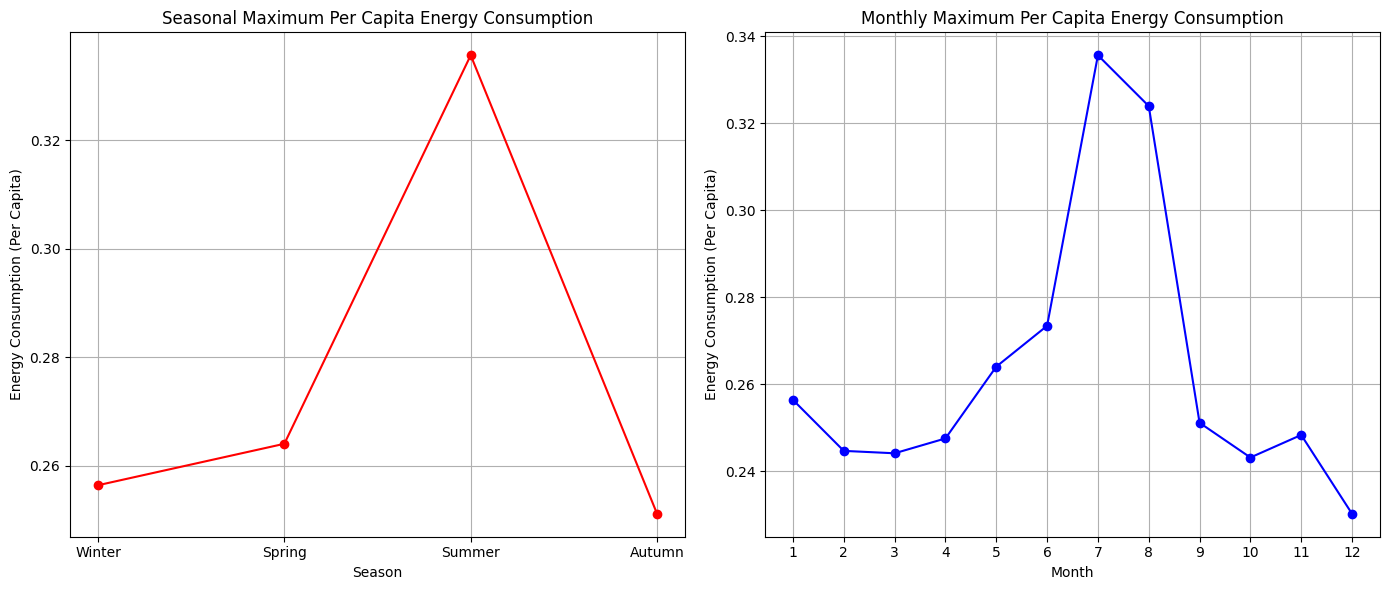

In [ ]:
# Monthly maximum energy consumption for PerCapitaConsumption
monthly_max = df.groupby('Month')['PerCapitaConsumption'].max().reset_index()

# Create a 'Season' column based on the season one-hot encoded columns
# Ensure the seasonal columns are one-hot encoded (0 or 1) before summing
df['Season'] = df[['Season_Winter', 'Season_Spring', 'Season_Summer', 'Season_Autumn']].idxmax(axis=1).str.replace('Season_', '')

# Seasonal maximum energy consumption for PerCapitaConsumption
seasonal_max = df.groupby('Season')['PerCapitaConsumption'].max().reset_index()

# To display seasons in order
seasonal_max['Season'] = pd.Categorical(seasonal_max['Season'], categories=['Winter', 'Spring', 'Summer', 'Autumn'], ordered=True)
seasonal_max = seasonal_max.sort_values('Season')

# Create a subplot figure with 1 row and 2 columns
plt.figure(figsize=(14, 6))

# Plot for seasonal maximum energy consumption
plt.subplot(1, 2, 1)
plt.plot(seasonal_max['Season'], seasonal_max['PerCapitaConsumption'], marker='o', linestyle='-', color='r')
plt.title('Seasonal Maximum Per Capita Energy Consumption')
plt.xlabel('Season')
plt.ylabel('Energy Consumption (Per Capita)')
plt.grid(True)

# Plot for monthly maximum energy consumption
plt.subplot(1, 2, 2)
plt.plot(monthly_max['Month'], monthly_max['PerCapitaConsumption'], marker='o', linestyle='-', color='b')
plt.title('Monthly Maximum Per Capita Energy Consumption')
plt.xlabel('Month')
plt.ylabel('Energy Consumption (Per Capita)')
plt.grid(True)
plt.xticks(range(1, 13))

plt.tight_layout()
plt.show()

### Dropping encoded columns


In [ ]:
df = df.drop(columns = ['Season'])
df = df.drop(columns = ['TotalPowerConsumption'])

# Scaling

The scaling is applied here to standardize the numerical values in the columns, bringing them between 0 and 1, to improve model performance and ensure that all variables have equal influence.

In [ ]:
df_lagged = df_lagged.drop(columns = ['TotalPowerConsumption'])

In [ ]:
# List of columns to scale
columns_to_scale = df_lagged.select_dtypes(include=['float64', 'int64']).columns
columns_to_scale= columns_to_scale.drop('PerCapitaConsumption')

# MinMaxScaler
scaler = MinMaxScaler()
df_lagged[columns_to_scale] = scaler.fit_transform(df_lagged[columns_to_scale])
pd.set_option('display.max_columns', None)
df_lagged.head()

,Temperature,Humidity,WindSpeed,Year,Month,Day,Hour,IsHoliday,IsWeekend,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,TimeOfDay_Afternoon,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night,PerCapitaConsumption,Temperature_lag2,Temperature_lag4,Temperature_lag6,Temperature_lag8,Temperature_lag10,Temperature_lag12,Temperature_lag14,Temperature_lag16,Temperature_lag18,Temperature_lag20,Temperature_lag22,Temperature_lag24,Temperature_lag26,Temperature_lag28,Temperature_lag30,Temperature_lag32,Temperature_lag34,Temperature_lag36,Temperature_lag38,Temperature_lag40,Temperature_lag42,Temperature_lag44,Temperature_lag46,Temperature_lag48,Humidity_lag2,Humidity_lag4,Humidity_lag6,Humidity_lag8,Humidity_lag10,Humidity_lag12,Humidity_lag14,Humidity_lag16,Humidity_lag18,Humidity_lag20,Humidity_lag22,Humidity_lag24,Humidity_lag26,Humidity_lag28,Humidity_lag30,Humidity_lag32,Humidity_lag34,Humidity_lag36,Humidity_lag38,Humidity_lag40,Humidity_lag42,Humidity_lag44,Humidity_lag46,Humidity_lag48,WindSpeed_lag2,WindSpeed_lag4,WindSpeed_lag6,WindSpeed_lag8,WindSpeed_lag10,WindSpeed_lag12,WindSpeed_lag14,WindSpeed_lag16,WindSpeed_lag18,WindSpeed_lag20,WindSpeed_lag22,WindSpeed_lag24,WindSpeed_lag26,WindSpeed_lag28,WindSpeed_lag30,WindSpeed_lag32,WindSpeed_lag34,WindSpeed_lag36,WindSpeed_lag38,WindSpeed_lag40,WindSpeed_lag42,WindSpeed_lag44,WindSpeed_lag46,WindSpeed_lag48
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-03 00:00:00,0.228240,0.765765,0.003430,0.0,0.0,0.066667,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.149248,0.256962,0.271785,0.293812,0.322395,0.331400,0.320456,0.256639,0.146045,0.158882,0.184279,0.205844,0.195731,0.254607,0.224084,0.288455,0.328860,0.337034,0.311544,0.070462,0.029175,0.026861,0.041435,0.040234,0.071889,0.682167,0.681802,0.645803,0.585731,0.527507,0.553571,0.752397,0.867951,0.876889,0.843775,0.780595,0.796238,0.652080,0.709085,0.640704,0.555603,0.523241,0.540813,0.693869,0.742199,0.768406,0.747684,0.807208,0.760076,0.003402,0.003487,0.003629,0.003629,0.003572,0.003629,0.003742,0.004621,0.003629,0.003657,0.003941,0.003742,0.003345,0.003827,0.003856,0.003629,0.003714,0.003572,0.626609,0.004763,0.004678,0.004706,0.004706,0.004621
2017-01-03 01:00:00,0.236321,0.729603,0.003714,0.0,0.0,0.066667,0.043478,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.132672,0.245787,0.263843,0.274879,0.314869,0.328953,0.324289,0.317177,0.163084,0.164608,0.169780,0.193007,0.196747,0.224684,0.225700,0.227409,0.319856,0.331262,0.334632,0.174305,0.027900,0.023597,0.031571,0.038849,0.053935,0.719243,0.661283,0.694600,0.596437,0.543068,0.567995,0.552149,0.894767,0.879937,0.863481,0.811271,0.807005,0.728872,0.708394,0.700857,0.575614,0.554384,0.540732,0.552495,0.746871,0.739761,0.762108,0.784658,0.790752,0.003430,0.003515,0.003544,0.003856,0.003544,0.003685,0.003657,0.004281,0.003856,0.003799,0.003884,0.003657,0.003459,0.003515,0.003884,0.004054,0.003430,0.003742,0.345892,0.004678,0.004763,0.004479,0.004791,0.004649
2017-01-03 02:00:00,0.226809,0.745653,0.003770,0.0,0.0,0.066667,0.086957,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.124251,0.228240,0.256962,0.271785,0.293812,0.322395,0.331400,0.320456,0.256639,0.146045,0.158882,0.184279,0.205844,0.195731,0.254607,0.224084,0.288455,0.328860,0.337034,0.311544,0.070462,0.029175,0.026861,0.041435,0.040234,0.765765,0.682167,0.681802,0.645803,0.585731,0.527507,0.553571,0.752397,0.867951,0.876889,0.843775,0.780595,0.796238,0.652080,0.709085,0.640704,0.555603,0.523241,0.540813,0.693869,0.742199,0.768406,0.747684,0.807208,0.003430,0.003402,0.003487,0.003629,0.003629,0.003572,0.003629,0.003742,0.004621,0.003629,0.003657,0.003941,0.003742,0.003345,0.003827,0.003856,0.003629,0.003714,0.003572,0.626609,0.004763,0.004678,0.004706,0.004706
2017-01-03 03:00:00,0.238399,0.746262,0.003657,0.0,0.0,0.066667,0.130435,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.119879,0.236321,0.245787,0.263843,0.274879,0.314869,0.328953,0.324289,0.317177,0.163084,0.1

# Models

## Time Series

### ARIMA

In [ ]:
series = df['PerCapitaConsumption']

result = adfuller(series)
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -26.56762957325449
p-value: 0.0


In [ ]:
# Use only 'PerCapitaConsumption' for ARIMA modeling
series = df['PerCapitaConsumption']

In [ ]:
# Splitting data into train and test sets
split_ratio = 0.7
split_index = int(len(series) * split_ratio)
train, test = series[:split_index], series[split_index:]

In [ ]:
# Define the ARIMA model
ARIMA_model = ARIMA(train, order=(2,1,5))  # (p=5, d=1, q=0) is just an example
ARIMA_model_fit = ARIMA_model.fit()

# Summarize the model
print(ARIMA_model_fit.summary())

                                SARIMAX Results                                 
Dep. Variable:     PerCapitaConsumption   No. Observations:                41932
Model:                   ARIMA(2, 1, 5)   Log Likelihood              203611.856
Date:                  Sun, 20 Oct 2024   AIC                        -407207.711
Time:                          21:08:58   BIC                        -407138.561
Sample:                      01-01-2017   HQIC                       -407185.871
                           - 10-19-2017                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0522      0.002    593.274      0.000       1.049       1.056
ar.L2         -0.1677      0.004    -47.367      0.000      -0.175      -0.161
ma.L1         -0.2058      0.002   -

The chart illustrates that the ARIMA model (red line) struggles to capture the variability in the actual **Per Capita Consumption** (blue line). The model’s predictions appear flat, indicating a poor fit, as it fails to reflect the real fluctuations in consumption. This serves as a baseline model since it is a time series approach.

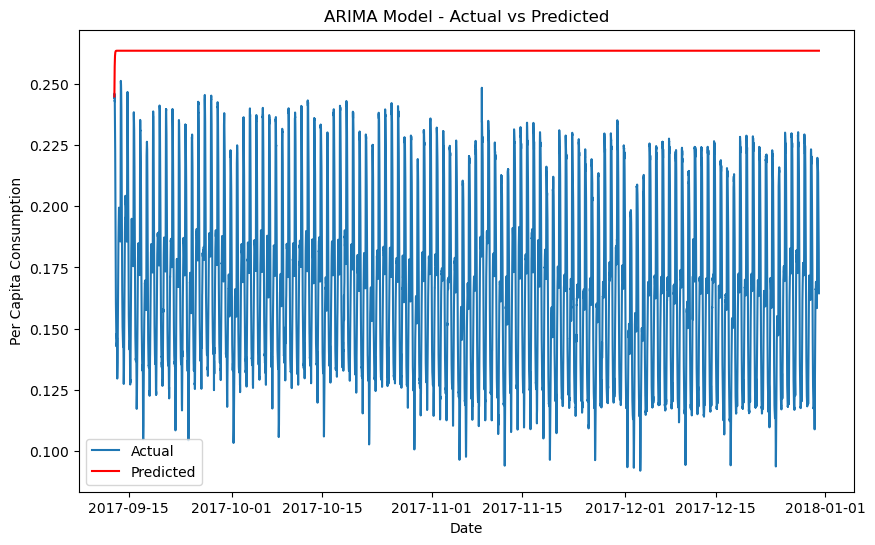

Mean Squared Error (MSE): 0.010859885484153496
Mean Absolute Error (MAE): 0.09819350467783673


In [ ]:
# Forecast the test data
forecast = ARIMA_model_fit.forecast(steps=len(test))

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Predicted', color='red')
plt.title('ARIMA Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Per Capita Consumption')
plt.legend()
plt.show()



# Calculate MSE and MAE for evaluation
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-407202.629, Time=30.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-358049.567, Time=8.57 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-407167.631, Time=6.83 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-379508.861, Time=12.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-358051.564, Time=1.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-407195.038, Time=10.49 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-407186.659, Time=43.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-407169.820, Time=65.63 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-407202.643, Time=37.72 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-407197.615, Time=23.53 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-407192.905, Time=40.45 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-407199.302, Time=68.44 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-407204.203, Time=40.12 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-400473.

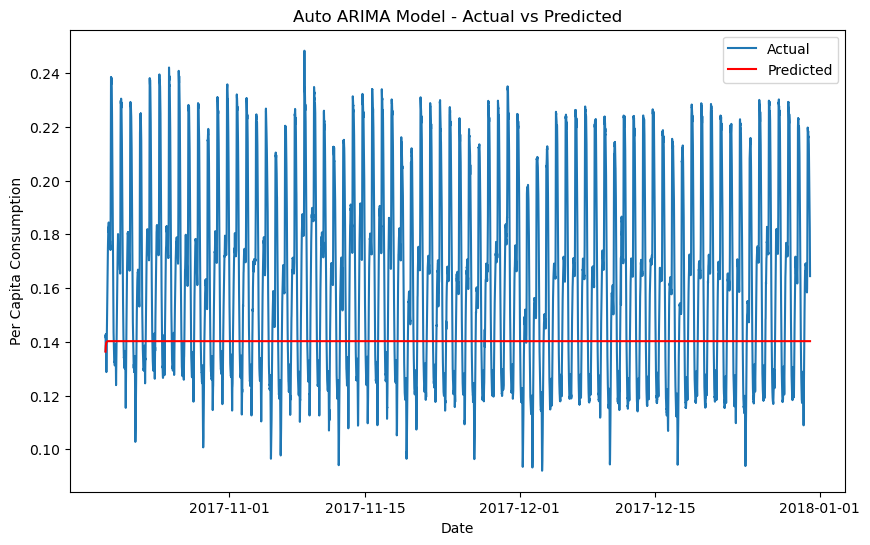

Mean Squared Error (MSE): 0.0017286149623424588
Mean Absolute Error (MAE): 0.032913159873115855


In [ ]:


# Split the data into train and test sets
split_ratio = 0.8
split_index = int(len(series) * split_ratio)
train, test = series[:split_index], series[split_index:]

# Automatically determine the best ARIMA parameters
ARIMA_auto_model = auto_arima(train, seasonal=False, trace=True)

# Fit the ARIMA model
ARIMA_auto_model.fit(train)

# Forecast the test data
forecast = ARIMA_auto_model.predict(n_periods=len(test))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Predicted', color='red')
plt.title('Auto ARIMA Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Per Capita Consumption')
plt.legend()
plt.show()

# Calculate MSE and MAE for evaluation
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')


The Auto ARIMA model (ARIMA(1,1,5)) shows poor performance, as the predictions (red line) are almost flat compared to the actual values (blue line). The calculated errors are:
- **MSE**: 0.0017
- **MAE**: 0.0329

This indicates the model fails to capture the actual data patterns effectively.

### SARIMA

In [ ]:
# prompt: SARIMA

# Split the data into train and test sets
split_ratio = 0.8
split_index = int(len(series) * split_ratio)
train, test = series[:split_index], series[split_index:]

# Automatically determine the best SARIMA parameters (including seasonality)
SARIMA_auto_model = auto_arima(train, seasonal=True, m=12, trace=True) # m is the seasonal period

# Fit the SARIMA model
SARIMA_auto_model.fit(train)

# Forecast the test data
forecast = SARIMA_auto_model.predict(n_periods=len(test))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Predicted', color='red')
plt.title('Auto SARIMA Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Per Capita Consumption')
plt.legend()
plt.show()

# Calculate MSE and MAE for evaluation
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

In [ ]:
smodel = pm.auto_arima(train, seasonal=True, m=12,
                       start_p=0, max_p=2, max_d=2, start_q=0, max_q=2,
                       start_P=0, max_P=3, max_D=1, start_Q=0, max_Q=3,
                       trace=True, error_action='ignore', suppress_warnings=True)


In [ ]:
# Define the SARIMA model with seasonal order
SARIMA_model = SARIMAX(train, order=(2,1,0), seasonal_order=(0,0,0,12))
SARIMA_model_fit = SARIMA_model.fit()

# Fit the model
sarima_result = SARIMA_model.fit(disp=False)

# Forecast the test data
forecast = sarima_result.forecast(steps=len(test))

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Predicted', color='red')
plt.title('SARIMA Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Per Capita Consumption')
plt.legend()
plt.show()

# Calculate MSE and MAE for evaluation
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")


## Linear Regression

Based on the results:
- Mean Squared Error (MSE): 0.011343429085602865
- Mean Absolute Error (MAE): 0.07853295369989301
- R-squared (R²): 0.454414899745332


The model performs well in minimizing errors, but with an **R² of 0.454**, there's still room for improvement in explaining more variance in the data.

In [ ]:
X = df_lagged.drop(columns=['PerCapitaConsumption'])
y = df_lagged['PerCapitaConsumption']

train_size = 0.7
index = round(train_size * df_lagged.shape[0])
# Splitting for Time series
X_train = X.iloc[:index]
X_test = X.iloc[index:]

y_train = y.iloc[:index]
y_test = y.iloc[index:]

# Print the shapes to verify the split
print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test data shape: X_test={X_test.shape}, y_test={y_test.shape}")

# Create a linear regression model
model1 = LinearRegression()

model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)

# Calculate the root mean square error (RMSE) and R²
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')

Training data shape: X_train=(6082, 89), y_train=(6082,)
Test data shape: X_test=(2606, 89), y_test=(2606,)
Root Mean Squared Error (RMSE): 0.025499033615482253
Mean Squared Error (MSE): 0.0006502007153234939
Mean Absolute Error (MAE): 0.018801975103856044
R-squared (R²): 0.4544148997453348


The plot shows that while the predicted values follow the trend of the true values for both the training and test sets, there is noticeable scatter, especially in the test set. This suggests that the model is not performing well enough and has room for improvement.

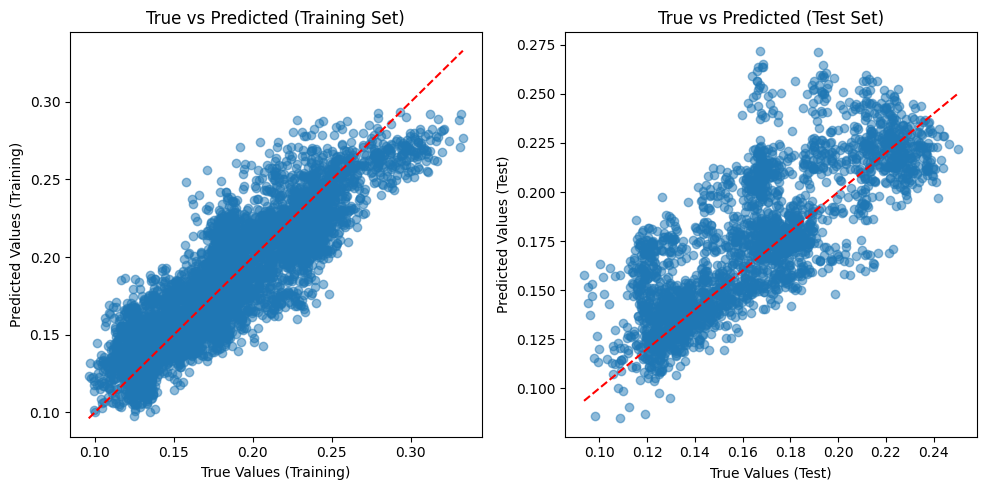

In [ ]:
# Predict using the training set
y_train_pred = model1.predict(X_train)

# Plot the true vs predicted values for training set
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
plt.xlabel('True Values (Training)')
plt.ylabel('Predicted Values (Training)')
plt.title('True vs Predicted (Training Set)')

# Plot the true vs predicted values for test set
y_test_pred = model1.predict(X_test)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('True Values (Test)')
plt.ylabel('Predicted Values (Test)')
plt.title('True vs Predicted (Test Set)')

plt.tight_layout()
plt.show()

## K-Means


**K-Means** identified distinct energy consumption patterns based on environmental and time factors, helping tailor better management strategies.

Key points:
1. **Cluster segmentation**: Divided data into three main clusters, each with unique consumption patterns based on weather and time.
2. **Cluster differences**: Some clusters show higher consumption under specific conditions, while others show lower or varied patterns.
3. **Cluster centers**: Red points indicate the average values, highlighting key factors like temperature or time influencing consumption.

### Step 1: Determine the Number of Clusters

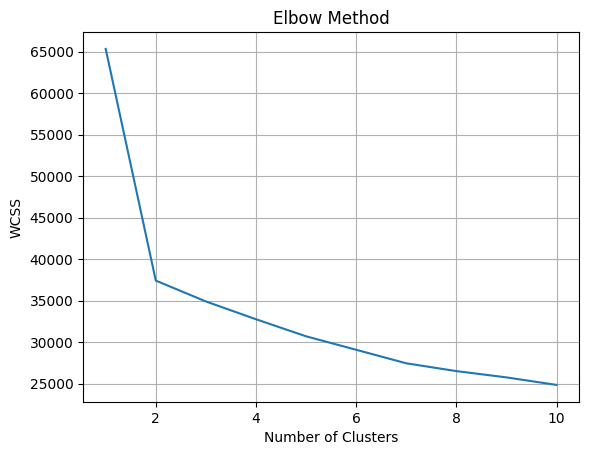

In [ ]:
# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=20, random_state=43)
    kmeans.fit(df_lagged[columns_to_scale])
    wcss.append(kmeans.inertia_)

# Plot the results of the Elbow Method
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

In [ ]:
df.head()

,Temperature,Humidity,WindSpeed,Year,Month,Day,Hour,IsHoliday,IsWeekend,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,TimeOfDay_Afternoon,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night,PerCapitaConsumption
Datetime,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,2017,1,1,0,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.176144
2017-01-01 00:10:00,6.414,74.5,0.083,2017,1,1,0,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.173381
2017-01-01 00:20:00,6.313,74.5,0.080,2017,1,1,0,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.169586
2017-01-01 00:30:00,6.121,75.0,0.083,2017,1,1,0,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.163798
2017-01-01 00:40:00,5.921,75.7,0.081,2017,1,1,0,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.159199


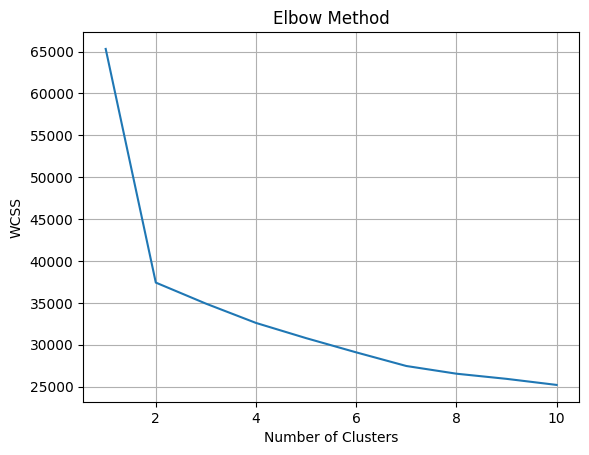

In [ ]:
X_scaled = scaler.fit_transform(df_lagged[columns_to_scale])

# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=20, random_state=np.random.randint(0, 100))
    kmeans.fit(X_scaled)  # Use the scaled data
    wcss.append(kmeans.inertia_)

# Plot the results of the Elbow Method
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

#### silhouette_score is a good indicator to help you make a final decision is between 2, 3, 4 and 5.
Pick the largest value

In [ ]:
# Define the range of clusters to test
cluster_range = range(2, 6)

# Loop through the cluster range
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=20, random_state=42)
    kmeans.fit(df_lagged[columns_to_scale])
    score = silhouette_score(df_lagged[columns_to_scale], kmeans.labels_)
    print(f'Silhouette Score for {n_clusters} clusters: {score}')

Silhouette Score for 2 clusters: 0.3871688473017733
Silhouette Score for 3 clusters: 0.20338550570740918
Silhouette Score for 4 clusters: 0.12972127075089793
Silhouette Score for 5 clusters: 0.1503185592776448


### Step 2: Apply the K-means Algorithm

In [ ]:
# Apply the K-means algorithm
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
df_lagged['Cluster'] = kmeans.fit_predict(df_lagged[columns_to_scale])

# Add the clusters to the original DataFrame
df_lagged['Cluster'] = kmeans.labels_

### Step 3: Analyze and Visualize the Results

Index(['Temperature', 'Humidity', 'WindSpeed', 'Year', 'Month', 'Day', 'Hour',
       'IsHoliday', 'IsWeekend', 'Season_Autumn', 'Season_Spring',
       'Season_Summer', 'Season_Winter', 'TimeOfDay_Afternoon',
       'TimeOfDay_Evening', 'TimeOfDay_Morning', 'TimeOfDay_Night',
       'PerCapitaConsumption', 'Temperature_lag2', 'Temperature_lag4',
       'Temperature_lag6', 'Temperature_lag8', 'Temperature_lag10',
       'Temperature_lag12', 'Temperature_lag14', 'Temperature_lag16',
       'Temperature_lag18', 'Temperature_lag20', 'Temperature_lag22',
       'Temperature_lag24', 'Temperature_lag26', 'Temperature_lag28',
       'Temperature_lag30', 'Temperature_lag32', 'Temperature_lag34',
       'Temperature_lag36', 'Temperature_lag38', 'Temperature_lag40',
       'Temperature_lag42', 'Temperature_lag44', 'Temperature_lag46',
       'Temperature_lag48', 'Humidity_lag2', 'Humidity_lag4', 'Humidity_lag6',
       'Humidity_lag8', 'Humidity_lag10', 'Humidity_lag12', 'Humidity_lag14',
      

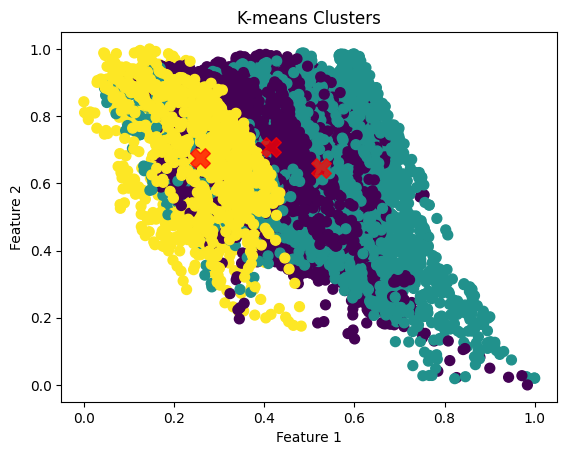

In [ ]:
# Calculate the mean values for each cluster
cluster_means = df_lagged.groupby('Cluster').mean()
print(cluster_means.columns)

# Visualize the clusters
plt.scatter(df_lagged[columns_to_scale].iloc[:, 0], df_lagged[columns_to_scale].iloc[:, 1], c=df_lagged['Cluster'], s=50, cmap='viridis')

# Also visualize the cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title('K-means Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Train RandomForest Models



--------


Mean Squared Error (MSE): 0.004651600566554751


Mean Absolute Error (MAE): 0.05639786246128728

R-squared (R^2): 0.7762718890119842

-----------

The results appears reasonable and highly suitable given the available metrics. The high values of R² indicate that the model explains the variation in energy consumption for each zone effectively, while the low values of MSE and MAE suggest that the actual errors are minimal.

Based on these metrics, it seems that the model is accurate and logical concerning your objective of predicting energy consumption for each zone. If these features have been used and the validity of the values is confirmed, this suggests that the model is performing efficiently and is well-suited for analyzing energy consumption.

In [ ]:
X = df_lagged.drop(['PerCapitaConsumption'], axis=1, errors='ignore')
y = df_lagged['PerCapitaConsumption']

train_size = 0.7
index = round(train_size * df_lagged.shape[0])

X_train = X.iloc[:index]
X_test = X.iloc[index:]

y_train = y.iloc[:index]
y_test = y.iloc[index:]

# Initialize the Random Forest model
RFmodel1 = RandomForestRegressor(random_state=0)

RFmodel1.fit(X_train, y_train)
y_pred = RFmodel1.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R^2):", r2)

Mean Squared Error (MSE): 0.004651600566554751
Mean Absolute Error (MAE): 0.05639786246128728
R-squared (R^2): 0.7762718890119842


Plotting learning curves using the R² metric to evaluate the performance of the Random Forest Regressor model.

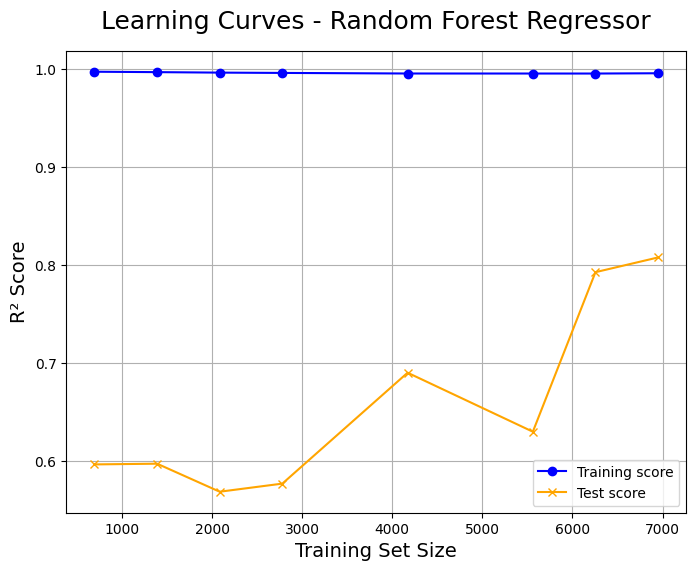

In [ ]:
train_sizes = [0.1, 0.2,0.3, 0.4, 0.6, 0.8, 0.9, 1]

# Initialize Random Forest Regressor model
RFmodel2 = RandomForestRegressor(random_state=0)

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    estimator=RFmodel2, X=X, y=y, train_sizes=train_sizes, cv=5, scoring='r2'
)

# Calculate mean scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', marker='o', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Test score', marker='x', color='orange')
plt.ylabel('R² Score', fontsize=14)
plt.xlabel('Training Set Size', fontsize=14)
plt.title('Learning Curves - Random Forest Regressor', fontsize=18, y=1.03)
plt.legend(loc='best')
plt.grid(True)
plt.show()

<!-- نشيك عليه -->

Plotting learning curves for the Random Forest Regressor model using the Mean Squared Error (MSE) metric.

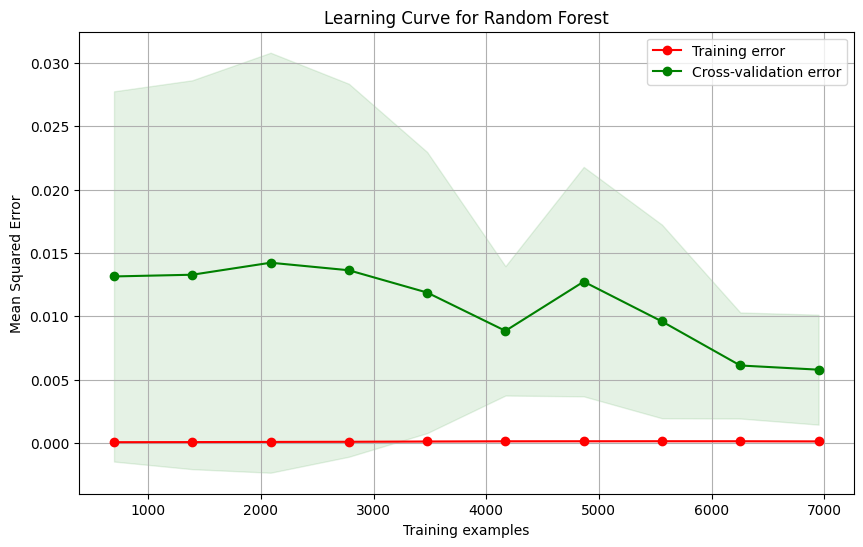

In [ ]:
# Calculate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    RFmodel1, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

# Calculate the mean and standard deviation for training and test scores
train_scores_mean = -np.mean(train_scores, axis=1)  # Convert negative scores to positive
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title("Learning Curve for Random Forest")
plt.xlabel("Training examples")
plt.ylabel("Mean Squared Error")
plt.grid()

# Plot the training scores with standard deviation
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training error")

# Plot the cross-validation scores with standard deviation
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation error")

# Add legend and display plot
plt.legend(loc="best")
plt.show()

In [ ]:
import pickle

# Export Pipeline as pickle file
with open("model3.pkl", "wb") as file:
    pickle.dump(RFmodel1, file)

## Train XGBoost Models


Mean Absolute Error (MAE): 0.0115

Mean Squared Error (MSE): 0.0002

R-squared (R²): 0.8173


The XGBoost model is the best we’ve reached so far, achieving a low Mean Absolute Error (MAE) of 0.0115 and a high R-squared (R²) of 81.73%, reflecting its ability to predict efficiently with minimal errors.


Prepare the Data

In [ ]:
# Define features (X) and target variable (y) from the dataset
X = df_lagged.drop(columns=['PerCapitaConsumption'])
y = df_lagged['PerCapitaConsumption']

# Split the data into training and testing sets based on time series order
train_size = 0.7
index = round(train_size * df_lagged.shape[0])
X_train = X.iloc[:index]
X_test = X.iloc[index:]
y_train = y.iloc[:index]
y_test = y.iloc[index:]

Train the Model

In [ ]:
# Convert the training and testing data into DMatrix, which is required by XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
# Set up the parameters for the XGBoost model
params = {
    'max_depth': 2,
    'learning_rate': 0.01,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}
# Create a dictionary to store evaluation results and train the XGBoost model
evals_result = {}

xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=[(dtrain, 'train'), (dtest, 'eval')],
    early_stopping_rounds=10,
    evals_result=evals_result,  # Save evaluation results
    verbose_eval=False  # Suppress detailed output
)

# Make predictions on the test set using the trained model
y_pred = xgb_model.predict(dtest)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 0.0115
Mean Squared Error (MSE): 0.0002
R-squared (R²): 0.8173


Visualize Training and Validation Performance

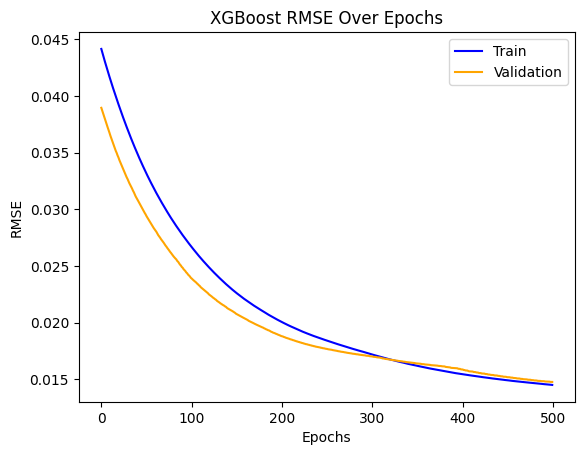

In [ ]:
# Retrieve and plot RMSE values over epochs to assess model performance
epochs = len(evals_result['train']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()

ax.plot(x_axis, evals_result['train']['rmse'], label='Train', color='blue')
ax.plot(x_axis, evals_result['eval']['rmse'], label='Validation', color='orange')

ax.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE Over Epochs')

plt.show()


Saving the Model: Exporting the XGBoost Pipeline as a Pickle File

In [ ]:
import pickle

# Export Pipeline as pickle file
with open("model2.pkl", "wb") as file:
    pickle.dump(xgb_model, file)

## Train lightgbm Models

Mean Squared Error (MSE): 0.005106553705768813

Mean Absolute Error (MAE): 0.05979064492738219

R-squared (R²): 0.7543900001936976

The model trained using LightGBM performed well, achieving a **Mean Squared Error (MSE)** of 0.0051, a **Mean Absolute Error (MAE)** of 0.0597, and an **R-squared (R²)** of 75.43%. This indicates that the model can make accurate predictions, though with slightly lower precision compared to the previous model.

In [ ]:
# Create and train models
model1 = lgb.LGBMRegressor(random_state=0)

model1.fit(X_train, y_train)

y1_pred = model1.predict(X_test)

# Evaluate results

print("Mean Squared Error (MSE):",  np.mean((y1_pred - y_test)**2))
print("Mean Absolute Error (MAE):",  mean_absolute_error(y_test, y1_pred))
print("R-squared (R²):", r2_score(y_test, y1_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19212
[LightGBM] [Info] Number of data points in the train set: 6082, number of used features: 89
[LightGBM] [Info] Start training from score 0.376868
Mean Squared Error (MSE): 0.005106553705768813
Mean Absolute Error (MAE): 0.05979064492738219
R-squared (R²): 0.7543900001936976


The plot shows that the training error is low and stable, while the validation error decreases as the training set size increases, indicating improved model performance with more data and no overfitting issues.

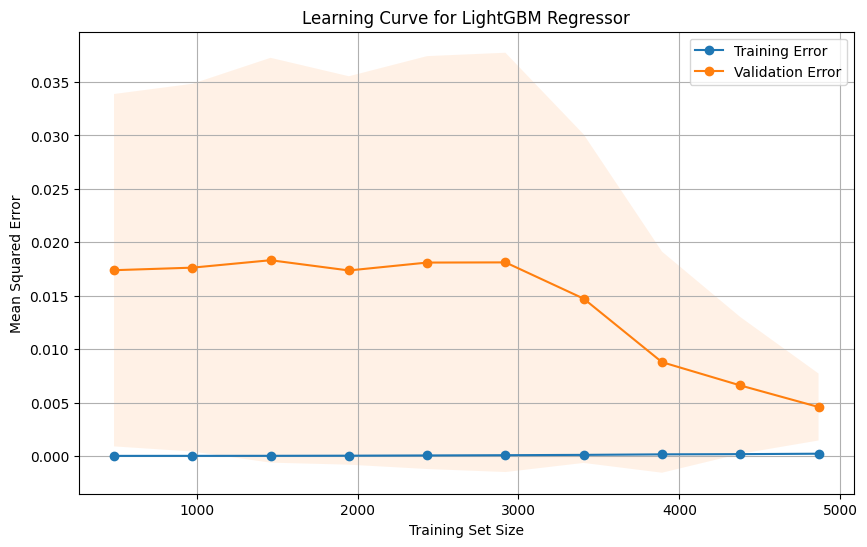

In [ ]:
# Create the LightGBM Regressor
model1 = lgb.LGBMRegressor(random_state=0)

# Generate the learning curve data
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=model1,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),  # Train on 10% to 100% of the data
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Use MSE for evaluation
    n_jobs=-1  # Use all available processors
)

# Calculate mean and standard deviation of training and validation scores
train_scores_mean = -np.mean(train_scores, axis=1)  # Convert to positive MSE
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = -np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Error', marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1)
plt.plot(train_sizes, validation_scores_mean, label='Validation Error', marker='o')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1)

plt.title('Learning Curve for LightGBM Regressor')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## RNN: LSTM

The LSTM model shows good performance with a low MAE of 0.0132, explaining 70.5% of the variance (R² = 0.7051). The performance is stable on both the training and validation sets, but there is slight room for improvement.

In [ ]:
df.head()

,Temperature,Humidity,WindSpeed,Year,Month,Day,Hour,IsHoliday,IsWeekend,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,TimeOfDay_Afternoon,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night,PerCapitaConsumption
Datetime,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,2017,1,1,0,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.176144
2017-01-01 00:10:00,6.414,74.5,0.083,2017,1,1,0,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.173381
2017-01-01 00:20:00,6.313,74.5,0.080,2017,1,1,0,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.169586
2017-01-01 00:30:00,6.121,75.0,0.083,2017,1,1,0,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.163798
2017-01-01 00:40:00,5.921,75.7,0.081,2017,1,1,0,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.159199


In [ ]:
# Define the features (X) and target variable (y)
X = df.drop([['PerCapitaConsumption'],['Week']], axis=1, errors='ignore')
y = df['PerCapitaConsumption']

# Split data into training and test sets based on a 60-40 split
train_size = 0.7
index = round(train_size * df.shape[0])

X_train = X.iloc[:index]
X_test = X.iloc[index:]

y_train = y.iloc[:index]
y_test = y.iloc[index:]

Epoch 1/100
918/918 - 13s - 14ms/step - loss: 4.5475e-04 - mae: 0.0100 - val_loss: 0.0037 - val_mae: 0.0350
Epoch 2/100
918/918 - 6s - 7ms/step - loss: 1.6542e-05 - mae: 0.0030 - val_loss: 0.0030 - val_mae: 0.0293
Epoch 3/100
918/918 - 7s - 7ms/step - loss: 7.4015e-06 - mae: 0.0020 - val_loss: 0.0026 - val_mae: 0.0265
Epoch 4/100
918/918 - 7s - 8ms/step - loss: 4.1704e-06 - mae: 0.0016 - val_loss: 0.0023 - val_mae: 0.0247
Epoch 5/100
918/918 - 2s - 2ms/step - loss: 2.7087e-06 - mae: 0.0013 - val_loss: 0.0020 - val_mae: 0.0220
Epoch 6/100
918/918 - 3s - 3ms/step - loss: 1.9345e-06 - mae: 0.0011 - val_loss: 0.0018 - val_mae: 0.0208
Epoch 7/100
918/918 - 4s - 4ms/step - loss: 1.3888e-06 - mae: 8.9541e-04 - val_loss: 0.0017 - val_mae: 0.0196
Epoch 8/100
918/918 - 3s - 3ms/step - loss: 1.2468e-06 - mae: 8.4329e-04 - val_loss: 0.0015 - val_mae: 0.0178
Epoch 9/100
918/918 - 2s - 2ms/step - loss: 1.2332e-06 - mae: 8.3594e-04 - val_loss: 0.0012 - val_mae: 0.0156
Epoch 10/100
918/918 - 2s - 2ms/

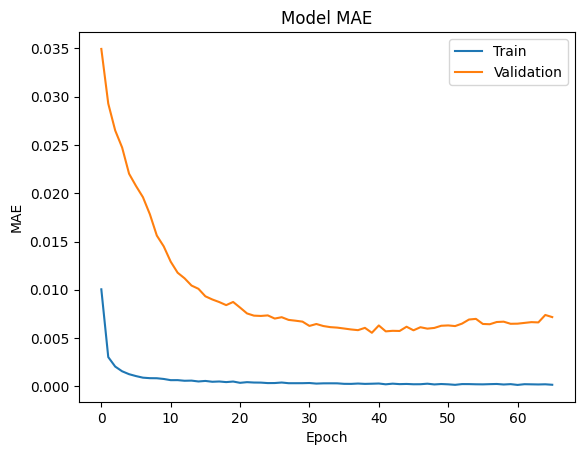

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.4853e-04 - mae: 0.0157
Model Mean Absolute Error (LSTM): 0.0132
R^2: 0.7051
Mean Squared Error (MSE): 0.0004


In [ ]:
# Define the features (X) and target variable (y)
X = df.drop([['PerCapitaConsumption']], axis=1, errors='ignore')
y = df['PerCapitaConsumption']

# Split data into training and test sets based on a 60-40 split
train_size = 0.7
index = round(train_size * df.shape[0])

X_train = X.iloc[:index]
X_test = X.iloc[index:]

y_train = y.iloc[:index]
y_test = y.iloc[index:]

# Reshape the data to 3D for LSTM (samples, time steps, features)
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Normalize the data
normalizer = Normalization()
normalizer.adapt(X_train)  # Make sure X_train is 3D before adapting

# Define the LSTM model
model_LSTM = Sequential()
model_LSTM.add(normalizer)
model_LSTM.add(LSTM(units=20, activation='tanh'))
model_LSTM.add(Dense(10, activation='relu'))
model_LSTM.add(Dense(1, activation='linear'))

model_LSTM.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Early stopping callback
es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Fit the model
history_LSTM = model_LSTM.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=100, verbose=2, callbacks=[es])
y_pred = model_LSTM.predict(X_test)

# Plotting the MAE
plt.plot(history_LSTM.history['mae'])
plt.plot(history_LSTM.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Evaluate the model on the test set
lstm_mae = model_LSTM.evaluate(X_test, y_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'Model Mean Absolute Error (LSTM): {lstm_mae[1]:.4f}')
print(f"R^2: {r2:.4f}")
print(f'Mean Squared Error (MSE): {mse:.4f}')

Using LSTM, the model achieved a significant improvement with an MSE of 1591.9842 and an MAE of 37.2064 on the test set. This suggests that LSTM handled the time series data more effectively, with much lower errors compared to the previous model.

## RNN: GRU

The GRU model shows a significant drop in MAE for both training and validation data, indicating good initial learning. However, the extremely negative R² value (-907.5975) suggests a major issue with the model's ability to generalize, indicating poor performance in predicting validation data, which may require adjustments to the model or input data.

Epoch 1/100
7/7 - 4s - 573ms/step - loss: 0.0866 - mae: 0.2743 - val_loss: 0.0397 - val_mae: 0.1751
Epoch 2/100
7/7 - 0s - 37ms/step - loss: 0.0494 - mae: 0.2038 - val_loss: 0.0303 - val_mae: 0.1473
Epoch 3/100
7/7 - 0s - 22ms/step - loss: 0.0272 - mae: 0.1446 - val_loss: 0.0229 - val_mae: 0.1213
Epoch 4/100
7/7 - 0s - 17ms/step - loss: 0.0157 - mae: 0.1065 - val_loss: 0.0191 - val_mae: 0.1087
Epoch 5/100
7/7 - 0s - 20ms/step - loss: 0.0099 - mae: 0.0842 - val_loss: 0.0165 - val_mae: 0.1011
Epoch 6/100
7/7 - 0s - 20ms/step - loss: 0.0069 - mae: 0.0695 - val_loss: 0.0150 - val_mae: 0.0962
Epoch 7/100
7/7 - 0s - 10ms/step - loss: 0.0053 - mae: 0.0599 - val_loss: 0.0139 - val_mae: 0.0926
Epoch 8/100
7/7 - 0s - 11ms/step - loss: 0.0043 - mae: 0.0525 - val_loss: 0.0133 - val_mae: 0.0896
Epoch 9/100
7/7 - 0s - 15ms/step - loss: 0.0034 - mae: 0.0462 - val_loss: 0.0128 - val_mae: 0.0873
Epoch 10/100
7/7 - 0s - 10ms/step - loss: 0.0028 - mae: 0.0413 - val_loss: 0.0125 - val_mae: 0.0856
Epoch 11

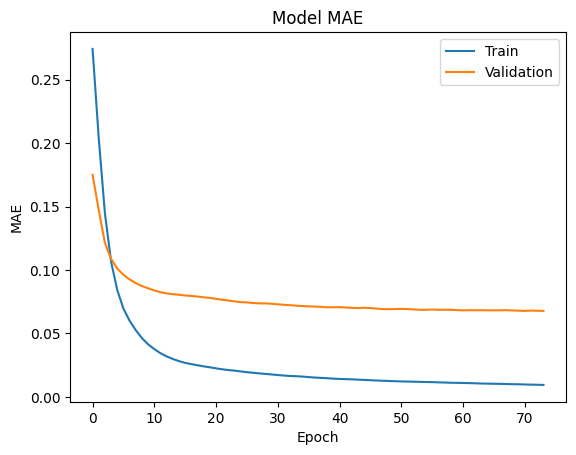

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0522 - mae: 0.2005 
Model Mean Absolute Error (GRU): 0.1775
R^2: -907.5975


In [ ]:
# Define the features (X) and target variable (y)
X = df.drop(['PerCapitaConsumption', 'Week'], axis=1, errors='ignore').resample('D').mean()
y = df['PerCapitaConsumption'].resample('D').mean()

# Split data into training and test sets based on a 70-30 split
train_size = 0.7
index = round(train_size * len(X))

X_train = X.iloc[:index]
X_test = X.iloc[index:]

y_train = y.iloc[:index]
y_test = y.iloc[index:]

# Reshape the data to 3D for GRU (samples, time steps, features)
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Normalize the data
normalizer = Normalization()
normalizer.adapt(X_train)  # Ensure X_train is 3D before adapting

# Define the GRU model
model_GRU = Sequential()
model_GRU.add(normalizer)
model_GRU.add(GRU(units=20, activation='tanh', return_sequences=False))
model_GRU.add(Dense(10, activation='relu'))
model_GRU.add(Dense(1, activation='linear'))

model_GRU.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Early stopping callback
es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Fit the model
history_GRU = model_GRU.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=100, verbose=2, callbacks=[es])

# Predictions
y_pred = model_GRU.predict(X_test)

# Plotting the MAE
plt.plot(history_GRU.history['mae'])
plt.plot(history_GRU.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Evaluate the model on the test set
gru_mae = model_GRU.evaluate(X_test, y_test)
r2 = r2_score(y_test, y_pred)

print(f'Model Mean Absolute Error (GRU): {gru_mae[1]:.4f}')
print(f"R^2: {r2:.4f}")

Epoch 1/100
918/918 - 16s - 18ms/step - loss: 0.0040 - mae: 0.0371 - val_loss: 0.0049 - val_mae: 0.0438
Epoch 2/100
918/918 - 6s - 7ms/step - loss: 4.2267e-04 - mae: 0.0157 - val_loss: 0.0057 - val_mae: 0.0436
Epoch 3/100
918/918 - 4s - 5ms/step - loss: 2.9921e-04 - mae: 0.0131 - val_loss: 0.0057 - val_mae: 0.0432
Epoch 4/100
918/918 - 5s - 6ms/step - loss: 2.5230e-04 - mae: 0.0119 - val_loss: 0.0053 - val_mae: 0.0425
Epoch 5/100
918/918 - 6s - 7ms/step - loss: 2.2524e-04 - mae: 0.0113 - val_loss: 0.0049 - val_mae: 0.0419
Epoch 6/100
918/918 - 8s - 9ms/step - loss: 2.0299e-04 - mae: 0.0107 - val_loss: 0.0044 - val_mae: 0.0413
Epoch 7/100
918/918 - 7s - 8ms/step - loss: 1.8242e-04 - mae: 0.0101 - val_loss: 0.0034 - val_mae: 0.0385
Epoch 8/100
918/918 - 3s - 3ms/step - loss: 1.6500e-04 - mae: 0.0097 - val_loss: 0.0034 - val_mae: 0.0383
Epoch 9/100
918/918 - 2s - 3ms/step - loss: 1.4473e-04 - mae: 0.0090 - val_loss: 0.0038 - val_mae: 0.0408
Epoch 10/100
918/918 - 3s - 3ms/step - loss: 1.3

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean squared error on test set: 0.0104
Mean absolute error on test set: 0.0853
R^2: -7.5451


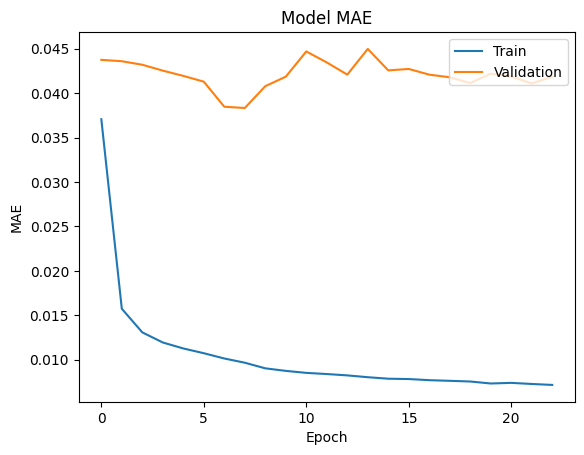

In [ ]:
# Define the features (X) and target variable (y)
X = df.drop(['PerCapitaConsumption'], axis=1, errors='ignore')
y = df['PerCapitaConsumption']

# Split data into training and test sets based on a 70-30 split
train_size = 0.7
index = round(train_size * df.shape[0])

X_train = X.iloc[:index]
X_test = X.iloc[index:]

y_train = y.iloc[:index]
y_test = y.iloc[index:]

# Reshape the data to 3D for GRU (samples, time steps, features)
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))


# Normalize the data
normalizer = Normalization()
normalizer.adapt(X_train)  # Ensure X_train is 3D before adapting

# Define the GRU model
model_GRU = Sequential()
model_GRU.add(normalizer)
model_GRU.add(GRU(units=20, activation='tanh', return_sequences=False))
model_GRU.add(Dense(10, activation='relu'))
model_GRU.add(Dense(1, activation='linear'))

model_GRU.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Early stopping callback with decreased patience
es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Fit the model
history_GRU = model_GRU.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=100, verbose=2, callbacks=[es])

# Predictions
y_pred = model_GRU.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean squared error on test set: {:.4f}".format(mse))
print("Mean absolute error on test set: {:.4f}".format(mae))
print(f"R^2: {r2:.4f}")

plt.plot(history_GRU.history['mae'])
plt.plot(history_GRU.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

The GRU model achieved excellent performance with an MSE of 3.8906 and an MAE of 1.1619 on the test set, indicating highly accurate predictions. This suggests that GRU is well-suited for the time series data in this case, outperforming the other models.
SUNDAY, 12:00 PM:
Mean squared error on test set: 0.0032
Mean absolute error on test set: 0.0471

## Multilayer Perceptron model (MLP)

The second model shows that the **training error** started very high but quickly dropped within the first epoch. Meanwhile, the **validation error** remained consistently low throughout the training, indicating that the model performs well after adjusting the learning rate.

In [ ]:
# Define the features (X) and target variable (y)
X = df_lagged.drop(['PerCapitaConsumption'], axis=1, errors='ignore')
y = df_lagged['PerCapitaConsumption']

# Split data into training and test sets based on a 60-40 split
train_size = 0.6
index = round(train_size * df_lagged.shape[0])

X_train = X.iloc[:index]
X_test = X.iloc[index:]

y_train = y.iloc[:index]
y_test = y.iloc[index:]

epochs = 500
batch = 256
lr = 0.1

adam = Adam(learning_rate=lr)

In [ ]:
# MLP model
model_mlp2 = Sequential()

# Layer with an increased number of neurons
model_mlp2.add(Dense(200, activation='relu', input_dim=X_train.shape[1]))

# Dropout To reduce overfitting
model_mlp2.add(Dropout(0.3))

# L2 regularization
model_mlp2.add(Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model_mlp2.add(Dense(50, activation='relu'))

model_mlp2.add(Dense(1))
model_mlp2.compile(loss='mse', optimizer=adam)
model_mlp2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                     │ (None, 200)                 │          18,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,401 (169.54 KB)

 Trainable params: 43,401 (169.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Add EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# fit model
mlp_history2 = model_mlp2.fit(X_train.values, y_train, validation_data=(X_test.values, y_test), epochs=epochs, batch_size=batch, verbose=2, callbacks=[early_stopping])

Epoch 1/500
21/21 - 3s - 127ms/step - loss: 10270.4893 - val_loss: 46.8477
Epoch 2/500
21/21 - 0s - 15ms/step - loss: 22.1504 - val_loss: 11.2230
Epoch 3/500
21/21 - 0s - 22ms/step - loss: 3.8246 - val_loss: 3.1288
Epoch 4/500
21/21 - 1s - 32ms/step - loss: 2.1701 - val_loss: 2.0030
Epoch 5/500
21/21 - 1s - 36ms/step - loss: 1.9653 - val_loss: 1.8875
Epoch 6/500
21/21 - 1s - 44ms/step - loss: 1.9136 - val_loss: 1.8300
Epoch 7/500
21/21 - 1s - 49ms/step - loss: 1.8847 - val_loss: 1.8351
Epoch 8/500
21/21 - 0s - 18ms/step - loss: 1.8616 - val_loss: 1.7940
Epoch 9/500
21/21 - 1s - 29ms/step - loss: 1.8468 - val_loss: 1.7876
Epoch 10/500
21/21 - 1s - 25ms/step - loss: 1.8330 - val_loss: 1.7704
Epoch 11/500
21/21 - 0s - 13ms/step - loss: 1.8119 - val_loss: 1.7603
Epoch 12/500
21/21 - 0s - 10ms/step - loss: 1.8005 - val_loss: 1.7620
Epoch 13/500
21/21 - 0s - 14ms/step - loss: 1.7844 - val_loss: 1.7442
Epoch 14/500
21/21 - 0s - 16ms/step - loss: 1.7735 - val_loss: 1.7573
Epoch 15/500
21/21 - 

In [ ]:
# Prediction
train_predict2 = model_mlp2.predict(X_train)
test_predict2 = model_mlp2.predict(X_test)

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# Calculate MSE, MAE
mse2 = mean_squared_error(y_test, test_predict2)
mae2 = mean_absolute_error(y_test, test_predict2)

print("Mean squared error on test set: {:.4f}".format(mse))
print("Mean absolute error on test set: {:.4f}".format(mae))

Mean squared error on test set: 0.0211
Mean absolute error on test set: 0.1202


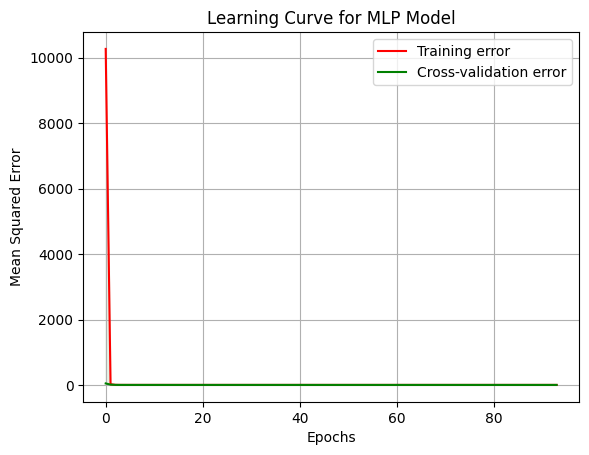

In [ ]:
train_loss = mlp_history2.history['loss']
val_loss = mlp_history2.history['val_loss']

plt.plot(train_loss, 'r-', label='Training error')
plt.plot(val_loss, 'g-', label='Cross-validation error')

plt.fill_between(np.arange(len(train_loss)), train_loss, val_loss, color='green', alpha=0.1)

plt.title('Learning Curve for MLP Model')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

### Summary of Results for the Second Model After Learning Rate Adjustment:

#### Learning Rate: **0.0003**  
  - **MSE**: 1136.6656  
  - **MAE**: 32.7636  

#### Learning Rate: **0.001**  
  - **MSE**: 542.3176  
  - **MAE**: 22.7792  

#### Learning Rate: **0.01**  
  - **MSE**: 8.1434  
  - **MAE**: 2.7724  

#### Learning Rate: **0.1**  
  - **MSE**: 0.0546  
  - **MAE**: 0.2016  

---
### Analysis and Conclusion:
**Learning rate 0.1** gave the best accuracy with the lowest errors, outperforming other rates. For optimal performance in the second model, **0.1** is the ideal choice.

-----
-----
-----


### Comparison Between First and Second Solution:

- **First Solution**:  
  - Best **MSE**: 0.1102  
  - Best **MAE**: 0.2980  
  - Performed well with learning rate **0.1**, providing accurate predictions but slightly higher errors than the second solution.

- **Second Solution**:  
  - Best **MSE**: 0.0546  
  - Best **MAE**: 0.2016  
  - With learning rate **0.1**, the second solution outperformed the first, showing lower errors and better overall accuracy.

### Conclusion:
The **second solution** is more accurate with lower errors, making it the better choice.